# Gaussian Process 

### Data Training

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from itertools import product

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
from elliptic_files.train_elliptic import samples_param
from elliptic_files.FEM_Solver import FEMSolver,Parametric_K
from Base.kernels_base import MaternKernel52,MaternKernel32,SquaredExponential
from Base.gp_base import VanillaGP, MultioutputGP
from elliptic_files.utilities import *
from elliptic_files.elliptic_pigp import Elliptic1DPIGP


import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [96]:
import numpy as np
from sklearn.gaussian_process.kernels import Matern, RBF

# Two sets of points
X1 = np.array([[0.0], [1.0], [2.0]])
X2 = np.array([[0.5], [1.5]])

# Define kernels
k_m32 = Matern(length_scale=1.0, nu=1.5)   # Matérn 3/2
k_m52 = Matern(length_scale=1.0, nu=2.5)   # Matérn 5/2
k_rbf = RBF(length_scale=1.0)              # Squared Exponential

# Compute kernel matrices
K_m32 = k_m32(X1, X2)
K_m52 = k_m52(X1, X1)
K_rbf = k_rbf(X1, X2)

print("Matérn 3/2 kernel:\n", K_m32)
print("\nMatérn 5/2 kernel:\n", K_m52)
print("\nRBF kernel:\n", K_rbf)

Matérn 3/2 kernel:
 [[0.78488765 0.26775661]
 [0.78488765 0.78488765]
 [0.26775661 0.78488765]]

Matérn 5/2 kernel:
 [[1.         0.52399411 0.13866022]
 [0.52399411 1.         0.52399411]
 [0.13866022 0.52399411 1.        ]]

RBF kernel:
 [[0.8824969  0.32465247]
 [0.8824969  0.8824969 ]
 [0.32465247 0.8824969 ]]


In [100]:
k_m32 = MaternKernel32()   # Matérn 3/2
k_m52 = MaternKernel52()   # Matérn 5/2
k_rbf = SquaredExponential()              # Squared Exponential

X1 = torch.tensor([[0.0], [1.0], [2.0]], dtype=torch.float64)
X2 = torch.tensor([[0.5], [1.5]], dtype=torch.float64)

# Compute kernel matrices
K_m32 = k_m32.covariance(X1, X2)
K_m52 = k_m52.d_euclidean_distance(X1, X2)[0][:,:,0]
K_rbf = k_rbf.covariance(X1, X2)

print("Matérn 3/2 kernel:\n", K_m32)
print("\nMatérn 5/2 kernel:\n", K_m52)
print("\nRBF kernel:\n", K_rbf)

Matérn 3/2 kernel:
 tensor([[0.7849, 0.2678],
        [0.7849, 0.7849],
        [0.2678, 0.7849]], dtype=torch.float64, grad_fn=<MulBackward0>)

Matérn 5/2 kernel:
 tensor([[-1., -1.],
        [ 1., -1.],
        [ 1.,  1.]], dtype=torch.float64)

RBF kernel:
 tensor([[0.8825, 0.3247],
        [0.8825, 0.8825],
        [0.3247, 0.8825]], dtype=torch.float64, grad_fn=<MulBackward0>)


In [4]:
def trainig_pigp(obs, nthetas, nparams, fobs =10,seed=0):
  thetas  = samples_param(nthetas,nparam=nparams,seed=seed)
  #print(thetas)


  fem_solver = FEMSolver(np.zeros(nparams),M=nparams,vert=50)
  obs_points = np.linspace(0,1,obs).reshape(-1,1)
  training_data = np.zeros((nthetas,obs ))

  for i,theta in enumerate(thetas):
      fem_solver.theta = theta
      fem_solver.solve()
      training_data[i,:] = fem_solver.evaluate_at_points(obs_points).reshape(1, -1)


  xf = torch.linspace(0,1,fobs).view(-1, 1)
  yf = (4*xf).reshape(-1,1) # training data
  x_bc = torch.tensor([0,1]).reshape(-1,1)
  y_bc = torch.tensor([0,2]).reshape(-1,1)

  data_training = {"parameters_data": torch.tensor(thetas).to(device),
                  "solutions_data": torch.tensor(training_data).to(device),
                  "x_solutions_data":obs_points,
                  "x_bc": x_bc.to(device),
                  "y_bc": y_bc.to(device),
                  "source_func_x": xf.to(device),
                  "source_func_f_x":yf.to(device)
                    }
  return data_training

In [5]:
obs, nthetas = 5, 1
nparams = 4

data_training = trainig_pigp(obs, nthetas, nparams,fobs=10,seed=200)
data_training_ = {"parameters_data":data_training["x_solutions_data"],"solutions_data":data_training["solutions_data"][0,:].reshape(-1,1)}
vanillagp = VanillaGP(data_training_)
vanillagp.train_gp()
vanillagp.optimize_gp()

Optimized kernel parameters:
log_sigma: log=0.326624, exp=1.386280
log_l: log=-0.584794, exp=0.557221


In [6]:
vanillagp.prediction(torch.tensor(data_training["x_solutions_data"]))

(tensor([[2.7572e-06],
         [1.0702e+00],
         [1.1436e+00],
         [1.4579e+00],
         [2.0000e+00]], dtype=torch.float64),
 tensor([[ 1.0000e-06,  4.8592e-12, -3.2836e-12,  1.3706e-12, -3.4289e-13],
         [ 4.8592e-12,  9.9999e-07,  9.7322e-12, -5.0249e-12,  1.3705e-12],
         [-3.2838e-12,  9.7320e-12,  9.9999e-07,  9.7320e-12, -3.2838e-12],
         [ 1.3706e-12, -5.0249e-12,  9.7320e-12,  9.9999e-07,  4.8590e-12],
         [-3.4289e-13,  1.3705e-12, -3.2836e-12,  4.8590e-12,  1.0000e-06]],
        dtype=torch.float64))

In [25]:
def pigp_training_data_generation(theta_obs,spatial_points_obs,kl_expansion, device):

    thetas = np.random.uniform(-1, 1, size=(theta_obs, kl_expansion))
    #thetas  = samples_param(theta_obs,nparam=kl_expansion)
    #print(thetas)
    fem_solver = FEMSolver(np.zeros(kl_expansion),M=kl_expansion,vert=75)
    obs_points = np.linspace(0,1,spatial_points_obs).reshape(-1,1)
    training_data = np.zeros((theta_obs,spatial_points_obs))

    for i,theta in enumerate(thetas):
        fem_solver.theta = theta
        fem_solver.solve()
        training_data[i,:] = fem_solver.evaluate_at_points(obs_points).reshape(1, -1)
        
    #xf = torch.linspace(1e-10,0.999,10).view(-1, 1)
    xf = torch.linspace(0,1,10).view(-1, 1)
    yf = (4*xf).reshape(-1,1) # training data
    x_bc = torch.tensor([0,1]).reshape(-1,1)
    y_bc = torch.tensor([0,2]).reshape(-1,1)

    data_training = {"parameters_data": torch.tensor(thetas).to(device),
                    "solutions_data": torch.tensor(training_data).to(device),
                    "x_solutions_data":torch.tensor(obs_points).to(device),
                    "x_bc": x_bc.to(device),
                    "y_bc": y_bc.to(device),
                    "source_func_x": xf.to(device),
                    "source_func_f_x":yf.to(device)
                    }
    return data_training

data_training = pigp_training_data_generation(150,8,4,device)

In [8]:
mine_gp = MultioutputGP(data_training)
mine_gp.train_gp()
mine_gp.optimize_gp()

Optimized kernel parameters:
log_sigma: log=-14.344582, exp=0.000001
log_l: log=0.994259, exp=2.702720
Optimized kernel parameters:
log_sigma: log=0.789265, exp=2.201777
log_l: log=2.639538, exp=14.006728
Optimized kernel parameters:
log_sigma: log=1.240658, exp=3.457888
log_l: log=2.633387, exp=13.920843
Optimized kernel parameters:
log_sigma: log=1.667792, exp=5.300450
log_l: log=2.739910, exp=15.485594
Optimized kernel parameters:
log_sigma: log=1.652728, exp=5.221201
log_l: log=2.726034, exp=15.272200
Optimized kernel parameters:
log_sigma: log=1.804741, exp=6.078395
log_l: log=2.811097, exp=16.628143
Optimized kernel parameters:
log_sigma: log=2.052520, exp=7.787502
log_l: log=3.047326, exp=21.058956
Optimized kernel parameters:
log_sigma: log=0.693030, exp=1.999765
log_l: log=16.727157, exp=18387045.669978


In [9]:
# Example data
X = data_training["parameters_data"]          # shape (n_samples, n_features)
y = data_training["solutions_data"]  # shape (n_samples, n_outputs=2)

# Define base GP
kernel = C(1) * Matern(length_scale=1, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
#gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)

# Wrap into multioutput
multi_gpr = MultiOutputRegressor(gpr)
multi_gpr.fit(X, y)


,estimator,GaussianProce...s_optimizer=5)
,n_jobs,None
,kernel,"1**2 * Matern...ale=1, nu=2.5)"
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,5
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,1**2


In [10]:
for i, estimator in enumerate(multi_gpr.estimators_):
    print(f"Output {i}:")
    print("  Optimized kernel:", estimator.kernel_)
    print("  Optimized kernel:", estimator.kernel_.bounds)
    print("  Sigma (constant):", estimator.kernel_.k1.constant_value)
    print("  Length scale:", estimator.kernel_.k2.length_scale)
    print("Alpha ", estimator.alpha)

Output 0:
  Optimized kernel: 0.00316**2 * Matern(length_scale=1e+05, nu=2.5)
  Optimized kernel: [[-11.51292546  11.51292546]
 [-11.51292546  11.51292546]]
  Sigma (constant): 9.999999999999997e-06
  Length scale: 100000.00000000001
Alpha  1e-10
Output 1:
  Optimized kernel: 2.23**2 * Matern(length_scale=14.1, nu=2.5)
  Optimized kernel: [[-11.51292546  11.51292546]
 [-11.51292546  11.51292546]]
  Sigma (constant): 4.963583419560074
  Length scale: 14.097839588392194
Alpha  1e-10
Output 2:
  Optimized kernel: 3.47**2 * Matern(length_scale=14, nu=2.5)
  Optimized kernel: [[-11.51292546  11.51292546]
 [-11.51292546  11.51292546]]
  Sigma (constant): 12.072402485719595
  Length scale: 13.95510685896499
Alpha  1e-10
Output 3:
  Optimized kernel: 5.31**2 * Matern(length_scale=15.5, nu=2.5)
  Optimized kernel: [[-11.51292546  11.51292546]
 [-11.51292546  11.51292546]]
  Sigma (constant): 28.165279631442015
  Length scale: 15.488798442924757
Alpha  1e-10
Output 4:
  Optimized kernel: 5.22**2

In [11]:
obs, nthetas = 8, 1000
nparam = 4
thetas  = samples_param(nthetas,nparam=nparam, seed=200)
fem_solver = FEMSolver(np.zeros(nparam),M=nparam,vert=50)
obs_points = np.linspace(0,1,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    fem_solver.solve()
    training_data[i,:] = fem_solver.evaluate_at_points(obs_points).reshape(1, -1)

In [12]:
mean = multi_gpr.predict(thetas)
print(mean)

[[0.         0.85731706 1.07140461 ... 1.35388226 1.18117903 2.        ]
 [0.         0.38293934 0.65282477 ... 1.5645503  1.74640055 2.        ]
 [0.         1.28418822 2.11780309 ... 2.58463911 1.72804612 2.        ]
 ...
 [0.         1.11085716 1.76594647 ... 1.92632553 1.31602064 2.        ]
 [0.         0.05321604 0.073078   ... 1.39207914 1.05687671 2.        ]
 [0.         0.99572255 2.11905556 ... 2.6746465  2.07206384 2.        ]]


In [13]:
mean_mine,var_mine = mine_gp.prediction(torch.tensor(thetas),var=True)
std_mine = torch.sqrt(var_mine)

print(std_mine)


tensor([[5.8915e-07, 2.0286e-02, 3.2283e-02,  ..., 3.6830e-02, 2.6470e-02,
         8.1651e-05],
        [5.8915e-07, 6.1714e-03, 9.7562e-03,  ..., 1.1031e-02, 7.8948e-03,
         8.1650e-05],
        [5.8915e-07, 1.5950e-02, 2.5390e-02,  ..., 2.8924e-02, 2.0762e-02,
         8.1651e-05],
        ...,
        [5.8915e-07, 2.1828e-02, 3.4748e-02,  ..., 3.9817e-02, 2.8747e-02,
         8.1652e-05],
        [5.8915e-07, 2.5828e-02, 4.1091e-02,  ..., 4.7295e-02, 3.4325e-02,
         8.1653e-05],
        [5.8915e-07, 1.1270e-02, 1.7908e-02,  ..., 2.0336e-02, 1.4567e-02,
         8.1651e-05]], dtype=torch.float64)


In [14]:
elliptic_gp = Elliptic1DPIGP(data_training,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device=device)
elliptic_gp.train_gp()
elliptic_gp.optimize_gp()

meanpigp, var = elliptic_gp.prediction(torch.tensor(thetas))
meanpigp = meanpigp.reshape(-1,obs)

Optimized kernel parameters:
log_sigma: log=0.080944, exp=1.084310
log_l: log=1.333478, exp=3.794215
log_sigma: log=0.080944, exp=1.084310
log_l: log=-1.153414, exp=0.315558


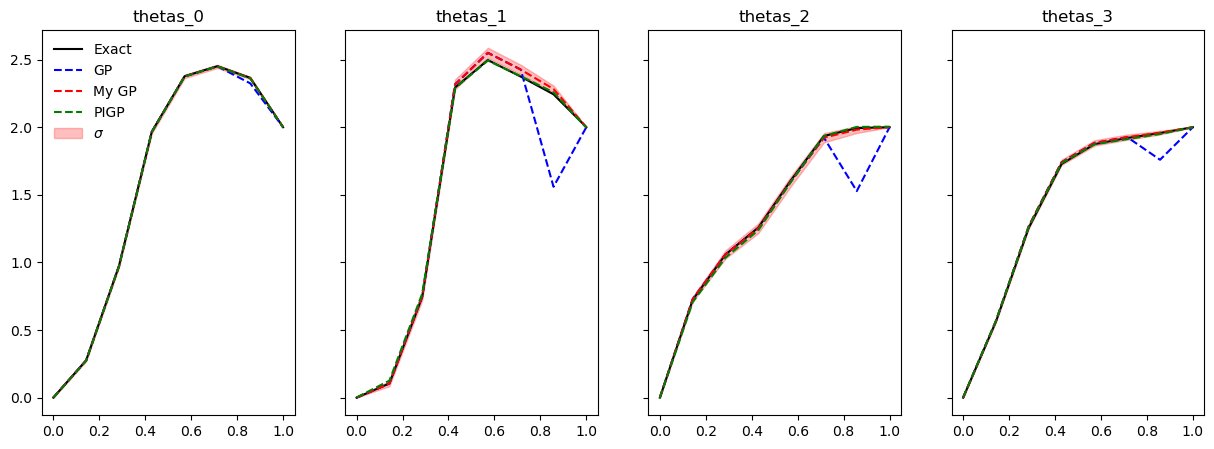

In [17]:
fig, axs = plt.subplots(1,4, figsize=(15, 5), sharey="row", sharex="row")

for i,j in enumerate(range(4,8)):
    axs[i].plot(obs_points,training_data[j,:], color = "black", label = "Exact")
    axs[i].plot(obs_points,mean[j,:],linestyle="--",color = "blue", label = "GP")
    axs[i].plot(obs_points,mean_mine[j,:],linestyle="--",color = "red", label = "My GP")
    axs[i].plot(obs_points,meanpigp[j,:],linestyle="--",color = "green", label = "PIGP")

    axs[i].fill_between(obs_points.flatten(),mean_mine[j,:].cpu().numpy().flatten() + std_mine[j,:].cpu().numpy(),mean_mine[j,:].cpu().numpy().flatten() - std_mine[j,:].cpu().numpy(), color = "r", alpha= 0.25, label =r"$\sigma$")
    axs[i].set_title(f"thetas_{i}")
axs[0].legend(frameon=False)

In [9]:
elliptic_gp.optimize_mll()

Optimized parameters:
(sigma_spatial,l_spatial) = (1.171040945929164,0.9842789076036718)
(sigma_parameter,l_parameter) = (1.1710409459327493,1.0)


In [30]:
# data_training = pigp_training_data_generation(150,10,4,device)

# elliptic_gp = Elliptic1DPIGP(data_training,kernel_parameter="MaternKernel52",device=device)
# elliptic_gp.train_gp()
# elliptic_gp.optimize_gp()

elliptic_gp1 = torch.load("./models/pigp_mean_kernel_spatialMatern52_kernel_parameterMatern52_spatial6_nsol75_kl4.pth")
elliptic_gp2 = torch.load("./models/pigp_mean_kernel_spatialMatern52_kernel_parameterMatern52_spatial6_nsol175_kl4.pth")

In [ ]:
samples = np.load(f'./results/FEM_mcmc_kl{4}_0.npy')
fine_model_eval = np.load(f'./results/FEM_mcmc_eval_kl{4}_0.npy')

total_error1 = []
total_error2 = []
for fine_eval,theta in zip(fine_model_eval,samples):
    theta = torch.tensor(theta,dtype=torch.float64)
    fine_eval = torch.tensor(fine_eval,dtype=torch.float64)

    surrogate_pred = elliptic_gp1.prediction(theta.reshape(1,-1),var=False)
    surrogate_pred = surrogate_pred
       
    error = (torch.linalg.norm((fine_eval.reshape(-1,1)-surrogate_pred.reshape(-1,1)),ord=2)**2).item()
    total_error1.append(error)

    surrogate_pred = elliptic_gp2.prediction(theta.reshape(1,-1),var=False)
    surrogate_pred = surrogate_pred.numpy()
       
    error = (torch.linalg.norm((fine_eval.reshape(-1,1)-surrogate_pred.reshape(-1,1)),ord=2)**2).item()
    total_error2.append(error)


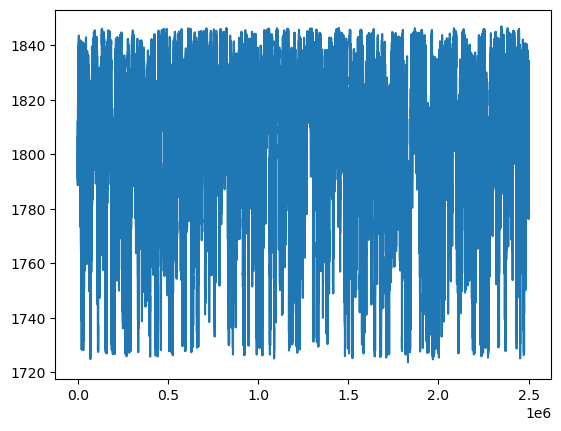

In [40]:
plt.plot(total_error1)

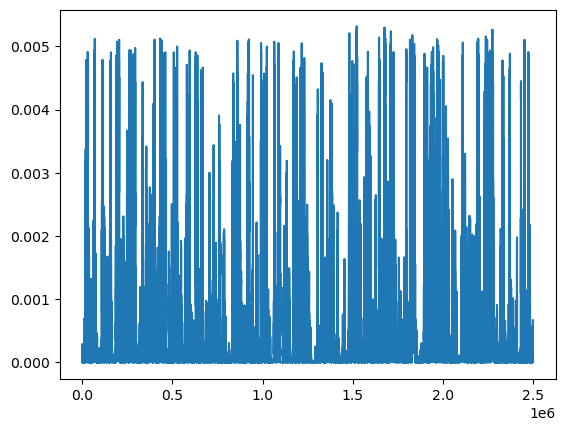

In [42]:
plt.plot(total_error2)

In [4]:

nspatial_points = [1,2,3,4,5,6,7,8,9,10]
nf_evaluations = [1,3,5,7,10,25,50]
nparam = 4
nsolutions = 10

gp_models = {str(k): [] for k in nspatial_points}
vanilla_gp = {i:[] for i in range(nsolutions)}

#multigp_model = {i:[] for i in range(nsolutions)}

for nobs, nfeval in product(nspatial_points, nf_evaluations):
    data_training = pigp_training_data_generation(nsolutions,nobs,nparam,feval=nfeval,device=device)

    elliptic_gp = Elliptic1DPIGP(data_training,kernel_parameter="MaternKernel52",device=device)
    elliptic_gp.train_gp()
    elliptic_gp.optimize_gp()

    gp_models[str(nobs)].append(elliptic_gp)

# multigp_model = MultioutputGP(data_training,kernel="MaternKernel52",device=device)
# multigp_model.train_gp()
# multigp_model.optimize_gp()

for i in range(nsolutions):
    for nobs in nspatial_points:
        data_training = pigp_training_data_generation(nsolutions,nobs,nparam,feval=nfeval,device=device)
        data_training_ = {"parameters_data":data_training["x_solutions_data"],"solutions_data":data_training["solutions_data"][i,:].reshape(-1,1)}
        vanillagp = VanillaGP(data_training_)
        vanillagp.train_gp()
        vanillagp.optimize_gp()

        vanilla_gp[i].append(vanillagp)



thetas = data_training["parameters_data"]

fem_solver = FEMSolver(np.zeros(nparam),M=nparam,vert=50)
obs_points = np.linspace(0,1,100).reshape(-1,1)
training_data = np.zeros((nsolutions,100))

for i,theta in enumerate(thetas):
      fem_solver.theta = theta
      fem_solver.solve()
      training_data[i,:] = fem_solver.evaluate_at_points(obs_points).reshape(1, -1)


errors = {i:{key:[] for key in gp_models.keys()} for i,theta in enumerate(thetas)}
cond_number_matrix = {i:{key:[] for key in gp_models.keys()} for i,theta in enumerate(thetas)}
errors_vanilla = {i:[] for i,theta in enumerate(thetas)}

for z,theta in enumerate(thetas):
    real_values = training_data[z,:]

    for i,key in enumerate(gp_models.keys()):

        elliptic_gps = gp_models[key]
        for j,model in enumerate(elliptic_gps):

            mean, var = model.prediction(torch.tensor(theta,device=device).reshape(1,-1),x_test=torch.tensor(obs_points,device=device).reshape(-1,1))
            cond_num = torch.linalg.cond(model.cov_matrix).item()

            error = np.linalg.norm((real_values.reshape(-1,1)-mean.numpy().reshape(-1,1)),ord=2)/np.linalg.norm((real_values.reshape(-1,1)),ord=2)
            errors[z][key].append(error)
            cond_number_matrix[z][key].append(cond_num)

for z,theta in enumerate(thetas):
    vanilla_gp_model = vanilla_gp[z]
    real_values = training_data[z,:]

    for model in vanilla_gp_model:
        mean, var = model.prediction(torch.tensor(obs_points,device=device).reshape(-1,1))
        error = np.linalg.norm((real_values.reshape(-1,1)-mean.numpy().reshape(-1,1)),ord=2)/np.linalg.norm((real_values.reshape(-1,1)),ord=2)
        errors_vanilla[z].append(error)


#thetas = np.random.uniform(-1, 1, size=(100, nparam))
# thetas = data_training["parameters_data"]

# fem_solver = FEMSolver(np.zeros(nparam),M=nparam,vert=50)
# obs_points = np.linspace(0.2,0.8,6).reshape(-1,1)
# training_data = np.zeros((100,6))

# for i,theta in enumerate(thetas):
#       fem_solver.theta = theta
#       fem_solver.solve()
#       training_data[i,:] = fem_solver.evaluate_at_points(obs_points).reshape(1, -1)


# errors = {i:{key:[] for key in gp_models.keys()} for i,theta in enumerate(thetas)}
# cond_number_matrix = {i:{key:[] for key in gp_models.keys()} for i,theta in enumerate(thetas)}
# #errors_vanilla = {i:[] for i,theta in enumerate(thetas)}
# errors_vanilla = []

# for z,theta in enumerate(thetas):
#     real_values = training_data[z,:]

#     for i,key in enumerate(gp_models.keys()):

#         elliptic_gps = gp_models[key]
#         for j,model in enumerate(elliptic_gps):

#             mean, var = model.prediction(torch.tensor(theta,device=device).reshape(1,-1))
#             cond_num = torch.linalg.cond(model.cov_matrix).item()

#             error = np.linalg.norm((real_values.reshape(-1,1)-mean.numpy().reshape(-1,1)),ord=2)/np.linalg.norm((real_values.reshape(-1,1)),ord=2)
#             errors[z][key].append(error)
#             cond_number_matrix[z][key].append(cond_num)

# # for z,theta in enumerate(thetas):
# #     real_values = training_data[z,:]
# #     mean, var = multigp_model.prediction(torch.tensor(theta,device=device).reshape(1,-1))
# #     error = np.linalg.norm((real_values.reshape(-1,1)-mean.numpy().reshape(-1,1)),ord=2)/np.linalg.norm((real_values.reshape(-1,1)),ord=2)
# #     errors_vanilla.append(error)

# for z,theta in enumerate(thetas):
#     vanilla_gp_model = vanilla_gp[z]
#     real_values = training_data[z,:]

#     for model in vanilla_gp_model:
#         mean, var = model.prediction(torch.tensor(obs_points,device=device).reshape(-1,1))
#         error = np.linalg.norm((real_values.reshape(-1,1)-mean.numpy().reshape(-1,1)),ord=2)/np.linalg.norm((real_values.reshape(-1,1)),ord=2)
#         errors_vanilla[z].append(error)


Optimized kernel parameters:
log_sigma: log=0.122785, exp=1.130641
log_l: log=2.437351, exp=11.442686
log_sigma: log=0.122785, exp=1.130641
log_l: log=-1.273640, exp=0.279811
Optimized kernel parameters:
log_sigma: log=0.047043, exp=1.048167
log_l: log=2.190929, exp=8.943519
log_sigma: log=0.047043, exp=1.048167
log_l: log=-0.946913, exp=0.387937
Optimized kernel parameters:
log_sigma: log=0.019287, exp=1.019474
log_l: log=2.164844, exp=8.713238
log_sigma: log=0.019287, exp=1.019474
log_l: log=-0.903756, exp=0.405045
Optimized kernel parameters:
log_sigma: log=-0.055621, exp=0.945898
log_l: log=2.071399, exp=7.935918
log_sigma: log=-0.055621, exp=0.945898
log_l: log=-1.002580, exp=0.366932
Optimized kernel parameters:
log_sigma: log=-0.090330, exp=0.913630
log_l: log=1.884361, exp=6.582149
log_sigma: log=-0.090330, exp=0.913630
log_l: log=-0.904374, exp=0.404795
Optimized kernel parameters:
log_sigma: log=0.005992, exp=1.006010
log_l: log=1.363148, exp=3.908476
log_sigma: log=0.005992,

In [5]:
nspatial_points = [1,2,3,4,5,6,7,8,9,10]
nf_evaluations = [1,3,5,7,10,25,50]
# Convert  to array for easy transpose
#keys = list(errors[0].keys())

mean_error_pigp = np.zeros((len(nf_evaluations),len(nspatial_points)))
mean_error_vanilla = np.zeros(len(nspatial_points))

for i in range(nsolutions):
    mean_error_pigp += np.array(list(errors[i].values())).T  # shape: (n_keys, n_points)
    mean_error_vanilla+= np.array(errors_vanilla[i])

mean_error_pigp=mean_error_pigp/nsolutions
mean_error_vanilla = mean_error_vanilla/nsolutions

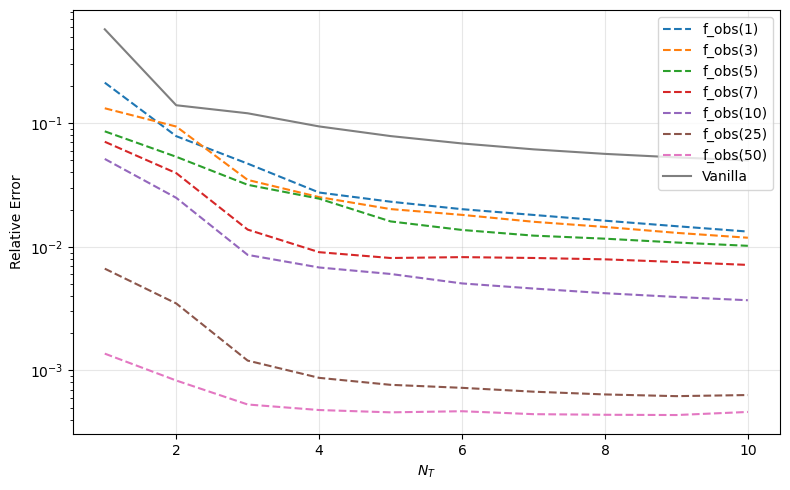

In [6]:
plt.figure(figsize=(8, 5))

for i, nfobs in enumerate(nf_evaluations):  # each row after transpose
    plt.semilogy(nspatial_points, mean_error_pigp[i],linestyle="--", label=f"f_obs({nfobs})")

plt.semilogy(nspatial_points,mean_error_vanilla, label = "Vanilla")

plt.xlabel("$N_{{T}}$")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
errors_vanilla

[0.0004880360193866242]

In [91]:
errors

{0: {'6': [0.0004886974864222254,
   0.0004891613618292264,
   0.0004878203773602844,
   0.0004923629568901715,
   0.0004907564612734246,
   0.0004937246680553145,
   0.0005000849072578595]}}

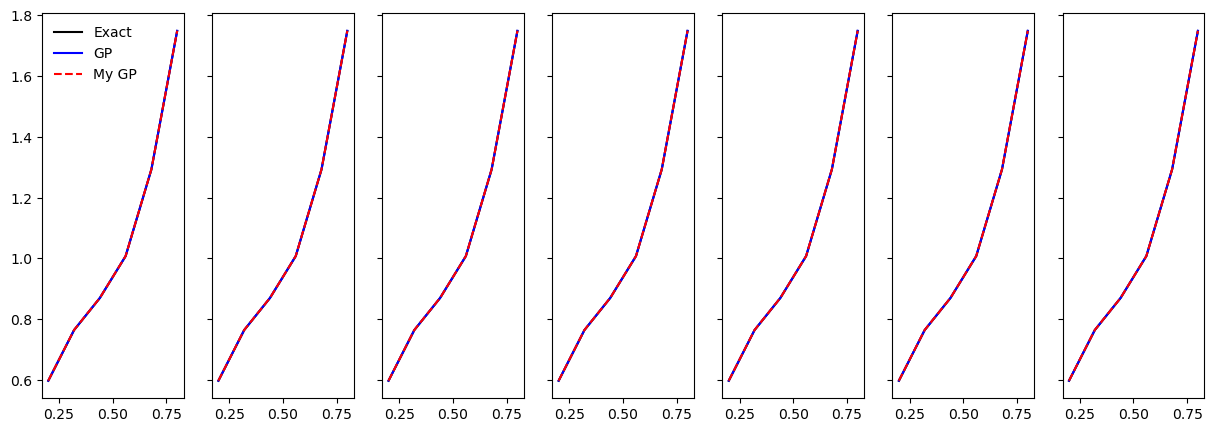

In [86]:
fig, axs = plt.subplots(thetas.shape[0],len(nf_evaluations), figsize=(15, 5), sharey="row", sharex="row")

for z,theta in enumerate(thetas):
    real_values = training_data[z,:]
    for i,key in enumerate(gp_models.keys()):
        elliptic_gps = gp_models[key]
        for j,model in enumerate(elliptic_gps):
            mean_mout, var = multigp_model.prediction(torch.tensor(theta,device=device).reshape(1,-1))
            axs[j].plot(obs_points,real_values, color = "black", label = "Exact")
            axs[j].plot(obs_points,mean_mout.reshape(-1,1),linestyle="-",color = "blue", label = "GP")            

            mean, var = model.prediction(torch.tensor(theta,device=device).reshape(1,-1))
            axs[j].plot(obs_points,mean.reshape(-1,1),linestyle="--",color = "red", label = "My GP")

            axs[0].legend(frameon=False)

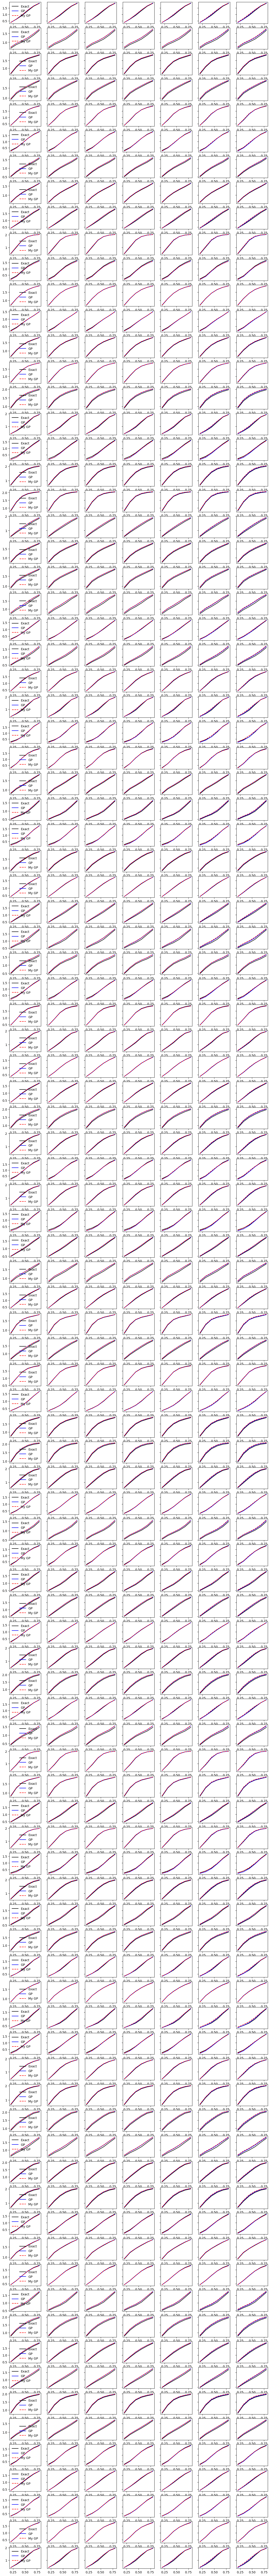

In [76]:
fig, axs = plt.subplots(thetas.shape[0],len(nf_evaluations), figsize=(15, 150), sharey="row", sharex="row")

for z,theta in enumerate(thetas):
    real_values = training_data[z,:]
    for i,key in enumerate(gp_models.keys()):
        elliptic_gps = gp_models[key]
        for j,model in enumerate(elliptic_gps):
            mean_mout, var = multigp_model.prediction(torch.tensor(theta,device=device).reshape(1,-1))
            axs[z,j].plot(obs_points,real_values, color = "black", label = "Exact")
            axs[z,j].plot(obs_points,mean_mout.reshape(-1,1),linestyle="-",color = "blue", label = "GP")            

            mean, var = model.prediction(torch.tensor(theta,device=device).reshape(1,-1))
            axs[z,j].plot(obs_points,mean.reshape(-1,1),linestyle="--",color = "red", label = "My GP")

            axs[z,0].legend(frameon=False)

In [68]:
nspatial_points = [6]
nf_evaluations = [1,3,5,7,10,25,50]

# Convert  to array for easy transpose
#keys = list(errors[0].keys())

mean_error_pigp = np.zeros((len(nf_evaluations),len(nspatial_points)))
mean_error_vanilla = np.zeros(len(nspatial_points))

for i in range(nsolutions):
    mean_error_pigp += np.array(list(errors[i].values())).T  # shape: (n_keys, n_points)
    mean_error_vanilla+= np.array(errors_vanilla[i])

mean_error_pigp=mean_error_pigp/nsolutions
mean_error_vanilla = mean_error_vanilla/nsolutions


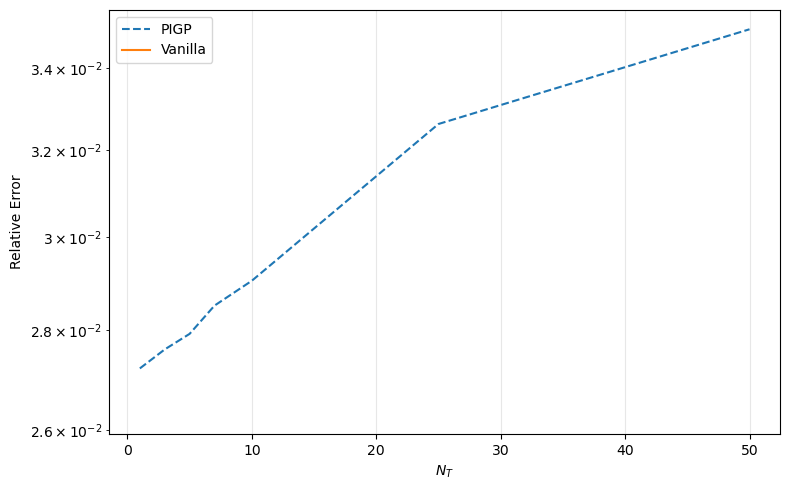

In [69]:
plt.figure(figsize=(8, 5))

plt.semilogy(nf_evaluations,mean_error_pigp,linestyle="--", label=f"PIGP")

plt.semilogy(nspatial_points,mean_error_vanilla, label = "Vanilla")

plt.xlabel("$N_{{T}}$")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()